In [1]:
# import the necessary packages

from imutils.perspective import four_point_transform, order_points
from matplotlib import pyplot as plt
from imutils import contours
import numpy as np
import argparse
import imutils
import math
import cv2

In [2]:

def draw_points(cnt, img, color):
    for p in cnt:
        p = tuple(p)
        cv2.circle(img, p, 3, color, -1)

In [3]:
def sort_contours_bound_rect(cnts, reverse=False):
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][2] * b[1][3], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return cnts, boundingBoxes


In [4]:
def show_img(img, size=12, title=None):
    fig = plt.gcf()
    fig.set_size_inches(size, size)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()


In [5]:
# define the dictionary of digit segments so we can identify
# each digit on the thermostat
DIGITS_LOOKUP = {
    (1, 1, 1, 0, 1, 1, 1): 0,
    (0, 0, 1, 0, 0, 1, 0): 1,
    (1, 0, 1, 1, 1, 0, 1): 2,
    (1, 0, 1, 1, 0, 1, 1): 3,
    (0, 1, 1, 1, 0, 1, 0): 4,
    (1, 1, 0, 1, 0, 1, 1): 5,
    (1, 1, 0, 1, 1, 1, 1): 6,
    (1, 1, 1, 0, 0, 1, 0): 7,
    (1, 1, 1, 1, 1, 1, 1): 8,
    (1, 1, 1, 1, 0, 1, 1): 9
}

## Control

In [65]:
input_file = "./boxed/5/26.jpg"
# input_file = "./example/recognize-digits-master/calculator.jpg"
largest_area = 1
skew = 5

image = cv2.imread(input_file)


In [66]:

# pre-process the image by resizing it, converting it to
# graycale, blurring it, and computing an edge map
image = imutils.resize(image, height=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 50, 200, 255)


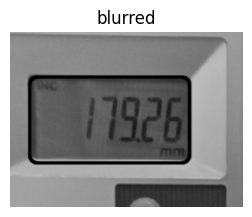

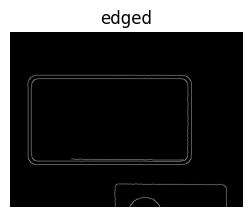

In [67]:
show_img(blurred, size=3, title="blurred")
show_img(edged, size=3, title="edged")

In [68]:
# find contours in the edge map, then sort them by their size in descending order
cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# somehow contourArea can not be used to sort the calculator rounded rectange area
# cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

# use boundingRect instead of contourArea
cnts, rcts = sort_contours_bound_rect(cnts, reverse=True)


In [ ]:
print(rcts)

In [200]:
print(len(cnts))

8


In [69]:
displayCnt = None



# loop over the contours
for i, c in enumerate(cnts):
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # if the contour is the fifth largest boundingRect, then we have found
    # the calculator display
    if i == largest_area:
        rect = cv2.minAreaRect(approx)  # get a rectangle rotated to have minimal area
        box = cv2.boxPoints(rect)  # get the box from the rectangle
        box = np.array(box, dtype="int")  # convert boxPoints to numpy array
        box = order_points(box)  # sort the box coordinates clock wise
        displayCnt = box  # the box is now the new contour.
        break


In [70]:
print("displayCnt: ", displayCnt)

displayCnt:  [[312. 376.]
 [626. 439.]
 [614. 499.]
 [300. 436.]]


In [71]:
# extract the calculator display, apply a perspective transform
# to it
warped = four_point_transform(gray, displayCnt.reshape(4, 2))
output = four_point_transform(image, displayCnt.reshape(4, 2))
edged = four_point_transform(edged, displayCnt.reshape(4, 2))

draw_points(displayCnt, image, (0, 255, 0))


C:\Users\USER\AppData\Local\Temp\ipykernel_16416\415105901.py:4: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(img, p, 3, color, -1)


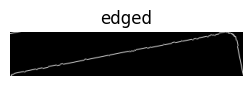

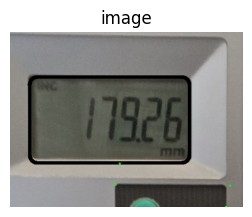

In [72]:
show_img(edged, size=3, title="edged")
show_img(image, size=3, title="image")

In [59]:
# the numbers displayed by the calculator a little bit leaning to right side
# we make them upright
height, width = warped.shape
width -= 1
height -= 1

skew += 0
warped = warped[skew:height, skew:width - skew]
output = output[skew:height, skew:width - skew]




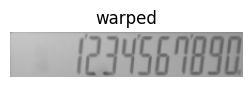

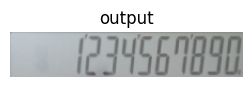

In [60]:
show_img(warped, size=3, title="warped")
show_img(output, size=3, title="output")

In [61]:
# threshold the warped image, then apply a series of morphological operations to cleanup the thresholded image
thresh = cv2.threshold(warped, 150, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

height, width = thresh.shape

# segment 2 and segment 5 separated so we do vertical dilate and erode to connect them
vert_dilate3 = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(1, 3))
thresh = cv2.dilate(thresh, vert_dilate3)
thresh = cv2.erode(thresh, vert_dilate3)


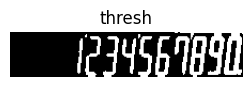

In [62]:
show_img(thresh, size=3, title="thresh")

In [63]:
# pad the image to prevent image border touching number
# thresh = cv2.copyMakeBorder(thresh, skew, skew, skew, skew, cv2.BORDER_CONSTANT, None, (0, 0, 0))

# find contours in the thresholded image, then initialize the digit contours lists
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cnts = imutils.grab_contours(cnts)
digitCnts = []


In [ ]:
print(cnts)

x:  105 y:  6 w:  13 h:  33
Appending to digitCnts
x:  63 y:  6 w:  5 h:  33
Appending to digitCnts
x:  168 y:  4 w:  16 h:  38
Appending to digitCnts
x:  154 y:  4 w:  14 h:  36
Appending to digitCnts
x:  136 y:  4 w:  14 h:  38
Appending to digitCnts
x:  120 y:  4 w:  13 h:  38
Appending to digitCnts
x:  87 y:  4 w:  15 h:  38
Appending to digitCnts
x:  70 y:  4 w:  15 h:  38
Appending to digitCnts
x:  120 y:  2 w:  2 h:  4
x:  70 y:  2 w:  2 h:  3
x:  159 y:  0 w:  59 h:  40
Appending to digitCnts
x:  154 y:  0 w:  3 h:  1
digitCnts:  [array([[[107,   6]],

       [[106,   7]],

       [[106,  11]],

       [[105,  12]],

       [[105,  20]],

       [[107,  22]],

       [[108,  22]],

       [[109,  23]],

       [[112,  23]],

       [[113,  24]],

       [[113,  31]],

       [[112,  32]],

       [[112,  37]],

       [[113,  38]],

       [[114,  38]],

       [[114,  35]],

       [[115,  34]],

       [[115,  21]],

       [[116,  20]],

       [[116,  14]],

       [[117,  

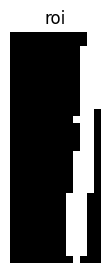

on is:  [0, 0, 0, 0, 0, 0, 0]


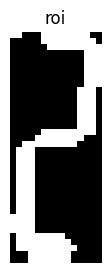

on is:  [0, 0, 0, 0, 0, 0, 0]


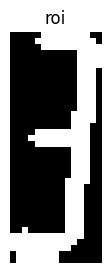

on is:  [0, 0, 0, 0, 0, 0, 0]
[1, 0, 1, 1, 0, 0, 1]


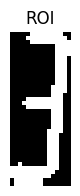

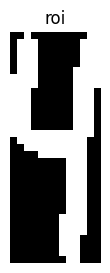

on is:  [0, 0, 0, 0, 0, 0, 0]


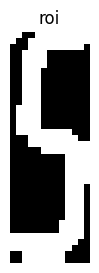

on is:  [0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 1, 0, 1, 1]


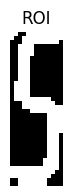

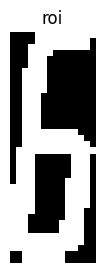

on is:  [0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 1, 1, 1, 1]


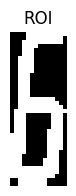

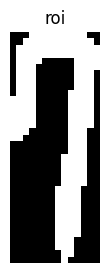

on is:  [0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 0, 0, 0, 0]


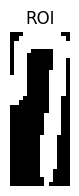

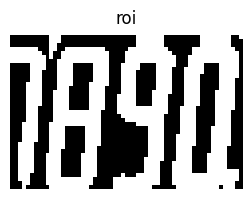

on is:  [0, 0, 0, 0, 0, 0, 0]


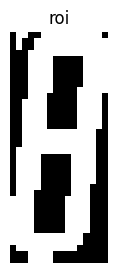

on is:  [0, 0, 0, 0, 0, 0, 0]


In [64]:

# loop over the digit area candidates
for c in cnts:
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)
    print("x: ", x, "y: ", y, "w: ", w, "h: ", h)
    # number 1 and 7 have small area
    # if the contour is sufficiently high, it must be a digit

    if 30 <= h <= 40:
        print("Appending to digitCnts")
        digitCnts.append(c)
print("digitCnts: ", digitCnts)
# sort the contours from left-to-right, then initialize the actual digits themselves
digitCnts = contours.sort_contours(digitCnts, method="left-to-right")[0]
digits = []

# cv2.drawContours(thresh, cnts, -1, (255, 255, 255), 1)

# fill in missing part of segment to pass the threshold
horz_dilate2 = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(2, 1))
vert_dilate2 = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(1, 2))
print("horz_dilate2: ", horz_dilate2)
print("vert_dilate2: ", vert_dilate2)

# loop over each of the digits
for c in digitCnts:
    # extract the digit ROI
    (x, y, w, h) = cv2.boundingRect(c)
    # manually override the width of number 1
    if w < 10:
        x -= 13 - w
        w = 13
    roi = thresh[y:y + h, x:x + w]
    show_img(roi, size=3, title="roi")

    # cv2.imshow("ROI", roi)
    # cv2.waitKey(0)

    # compute the width and height of each of the 7 segments
    # we are going to examine
    (roiH, roiW) = roi.shape
    (dW, dH) = (int(roiW * 0.25), int(roiH * 0.15))
    dHC = int(roiH * 0.05)

    # define the set of 7 segments special treatment for segment 0, 3 & 6
    segments = [
        ((2, 0), (w - 2, dH)),  # top
        ((0, 0), (dW, h // 2)),  # top-left
        ((w - dW, 0), (w, h // 2)),  # top-right
        ((5, (h // 2) - dHC), (w - 5, (h // 2) + dHC)),  # center
        ((0, h // 2), (dW, h)),  # bottom-left
        ((w - dW, h // 2), (w, h)),  # bottom-right
        ((2, h - dH), (w - 2, h))  # bottom
    ]
    on = [0] * len(segments)
    print("on is: ", on)

    # loop over the segments
    for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
        # extract the segment ROI, count the total number of thresholded pixels in the segment, and then compute
        # the area of the segment
        segROI = roi[yA:yB, xA:xB]
        if i in [1, 2, 4, 5]:
            segROI = cv2.dilate(segROI, horz_dilate2)
        else:
            segROI = cv2.dilate(segROI, vert_dilate2)
        total = cv2.countNonZero(segROI)
        area = (xB - xA) * (yB - yA)
        # print(i, total / float(area))
        
        # if the total number of non-zero pixels is greater than
        # 35% of the area, mark the segment as "on"
        if total / float(area) > 0.5:
            on[i] = 1

    # print(on)
    # lookup the digit and draw it on the image
    # give -1 for lookup failure
    if tuple(on) in DIGITS_LOOKUP.keys():
        digit = DIGITS_LOOKUP[tuple(on)]
    else:
        digit = -1
        print(on)
        show_img(roi, size=2, title="ROI")
        
    # print(digit)
    digits.append(digit)
    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
    cv2.putText(output, str(digit), (x + 1, y + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 0), 1)



[1, 2, -1, 4, -1, -1, -1, 8, 2]


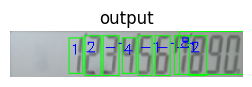

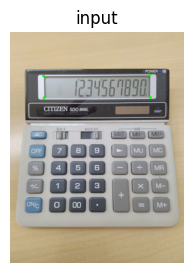

In [52]:
print(digits)
show_img(output, size=3, title="output")
show_img(image, size=3, title="input")